In [ ]:
!sudo apt-get install -y swig
# Install the 'gym' package
# Install the 'gym' package
!pip install -q -U gym

# Install the 'gym' package with the optional 'box2d' extras
!pip install -q -U gym[box2d]


In [ ]:
import gym                   # Import the Gym library for reinforcement learning environments
import tensorflow as tf     # Import TensorFlow for deep learning functionalities
import numpy as np          # Import NumPy for numerical operations
import matplotlib.animation     # Import the animation module from Matplotlib
import matplotlib.pyplot as plt     # Import Matplotlib for plotting functionalities

# Set font size and styling for Matplotlib
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [ ]:
def update_scene(num, frames, patch):
    # Update the data of the patch with the corresponding frame
    patch.set_data(frames[num])
    return patch,

    
def plot_animation(frames, repeat=False, interval=40):
    # Create a new figure
    fig = plt.figure()

    # Create a patch and set the initial image
    patch = plt.imshow(frames[0])

    # Turn off the axis
    plt.axis('off')

    # Create the animation using FuncAnimation
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)

    # Close the figure to avoid displaying it
    plt.close()

    # Return the animation
    return anim


In [ ]:
def search(dis_factor, episodes, iterations):
    # Hyperparameters
    n_iterations = iterations
    n_episodes_per_update = episodes
    n_max_steps = 1000
    discount_factor = dis_factor

    # Create the Gym environment
    env = gym.make("LunarLander-v2", render_mode="rgb_array")

    np.random.seed(42)
    tf.random.set_seed(42)

    # Define the dimensions of the input and output
    n_inputs = env.observation_space.shape[0]
    n_outputs = env.action_space.n

    # Define the neural network model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation="relu", input_shape=[n_inputs]),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(n_outputs, activation="softmax"),
    ])

    def lander_play_one_step(env, obs, model, loss_fn):
        # Perform one step in the environment
        with tf.GradientTape() as tape:
            probas = model(obs[np.newaxis])
            logits = tf.math.log(probas + tf.keras.backend.epsilon())
            action = tf.random.categorical(logits, num_samples=1)
            loss = tf.reduce_mean(loss_fn(action, probas))
        grads = tape.gradient(loss, model.trainable_variables)
        obs, reward, done, info, truncated = env.step(action[0, 0].numpy())
        return obs, reward, done, truncated, grads

    def lander_play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
        all_rewards = []
        all_grads = []
        for episode in range(n_episodes):
            current_rewards = []
            current_grads = []
            obs, info = env.reset()
            for step in range(n_max_steps):
                obs, reward, done, truncated, grads = lander_play_one_step(
                    env, obs, model, loss_fn)
                current_rewards.append(reward)
                current_grads.append(grads)
                if done or truncated:
                    break
            all_rewards.append(current_rewards)
            all_grads.append(current_grads)
        return all_rewards, all_grads

    def discount_rewards(rewards, discount_factor):
        # Compute discounted rewards
        discounted = np.array(rewards)
        for step in range(len(rewards) - 2, -1, -1):
            discounted[step] += discounted[step + 1] * discount_factor
        return discounted

    def discount_and_normalize_rewards(all_rewards, discount_factor):
        # Compute discounted and normalized rewards
        all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                                  for rewards in all_rewards]
        flat_rewards = np.concatenate(all_discounted_rewards)
        reward_mean = flat_rewards.mean()
        reward_std = flat_rewards.std()
        return [(discounted_rewards - reward_mean) / reward_std
                for discounted_rewards in all_discounted_rewards]

    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.005)
    loss_fn = tf.keras.losses.sparse_categorical_crossentropy

    env.reset(seed=42)

    mean_rewards = []

    for iteration in range(n_iterations):
        all_rewards, all_grads = lander_play_multiple_episodes(
            env, n_episodes_per_update, n_max_steps, model, loss_fn)
        mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
        print(f"\rIteration: {iteration + 1}/{n_iterations},"
              f" mean reward: {mean_reward:.1f}  ", end="")
        mean_rewards.append(mean_reward)
        all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                           discount_factor)
        all_mean_grads = []
        for var_index in range(len(model.trainable_variables)):
            mean_grads = tf.reduce_mean(
                [final_reward * all_grads[episode_index][step][var_index]
                 for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
            all_mean_grads.append(mean_grads)
        optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

    plt.xlabel("Iteration")
    plt.ylabel("Reward")
    plt.grid()
    plt.show()

    return sum(mean_rewards) / len(mean_rewards), model


Iteration: 300/300, mean reward: 114.3  

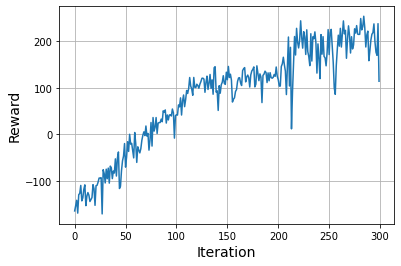

Discount factor : 0.99 Score : 81.17987050049112


In [ ]:
# 3 hours training time
dis_factors = [0.99]
episodes = [15]
best_score = -1000
for i in dis_factors:
  for j in episodes:
    score,model = search(i,j,300)
    print("Discount factor : "+str(i)+" Score : "+str(score))
    if(score > best_score):
      best_model = model
      best_dis = i
      best_episodes = j
      best_score = score

In [ ]:
def lander_render_policy_net(model, n_max_steps=500):
    frames = []  # List to store frames for animation
    env = gym.make("LunarLander-v2", render_mode="rgb_array")  # Create LunarLander-v2 environment
    obs, info = env.reset()  # Reset the environment and obtain initial observation
    for step in range(n_max_steps):
        frames.append(env.render())  # Append current frame to frames list for animation
        probas = model(obs[np.newaxis])  # Get action probabilities from the model
        logits = tf.math.log(probas + tf.keras.backend.epsilon())  # Compute logits for sampling action
        action = tf.random.categorical(logits, num_samples=1)  # Sample an action based on probabilities
        obs, reward, done, truncated, info = env.step(action[0, 0].numpy())  # Take the action in the environment
        if done or truncated:  # Break the loop if the episode is done or truncated
            break
    env.close()  # Close the environment
    return frames  # Return the frames for animation


In [ ]:
frames = lander_render_policy_net(model)
plot_animation(frames)